In [1]:
!pip install numpy as np
!pip install matplotlib as plt
!pip install torch
!pip install pandas as pd

ERROR: Could not find a version that satisfies the requirement as (from versions: none)
ERROR: No matching distribution found for as
ERROR: Could not find a version that satisfies the requirement as (from versions: none)
ERROR: No matching distribution found for as
ERROR: Could not find a version that satisfies the requirement as (from versions: none)
ERROR: No matching distribution found for as


In [160]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset

#Loading training data
bmi = pd.read_csv("bmi_train.csv")
bmi.replace({'Gender': {'Female': 0, 'Male': 1}}, inplace=True) #Gender -> boolean
bmi = bmi.to_numpy()

#Splitting off 80% of data for training, 20% for validation
train_split = int(0.8 * len(bmi))
bmi_train_data = torch.tensor(bmi[:train_split, [0,1,2]], dtype=torch.float32)
bmi_train_index = torch.tensor(bmi[:train_split, 3], dtype=torch.float32)
bmi_validation_data = torch.tensor(bmi[train_split:, [0,1,2]], dtype=torch.float32)
bmi_validation_index = torch.tensor(bmi[train_split:, 3], dtype=torch.float32)

#Loading prediction data
bmi_pred = pd.read_csv("bmi_validation.csv")
bmi_pred.replace({'Gender': {'Female': 0, 'Male': 1}}, inplace=True) #Gender -> boolean
bmi_prediction = torch.tensor(bmi_pred.to_numpy(), dtype=torch.float32)

#Generate empty predictions on index
#prediction_index = len(bmi_pred.index)

In [161]:
torch.manual_seed(42)

class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(3, 1, #tensor size (3,1) for 3 variables and 1 output
                                               dtype=torch.float),
                                  requires_grad=True) #we can update this value with gradient descent
#        self.bias = nn.Parameter(torch.randn(1,
#                                            dtype=torch.float),
#                                requires_grad=True)
    #define one computation step as forward
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.transpose(self.weights, 0, 1) * x # + self.bias #regression formula

In [162]:
#Create instance of model
model_0 = LinearRegressionModel()

#Check nn.Parameters in the nn.Module subclass created
list(model_0.parameters())

[Parameter containing:
 tensor([[0.3367],
         [0.1288],
         [0.2345]], requires_grad=True)]

In [163]:
#Make prediction with our model, inference = make prediction
#Inference mode make forward() passes faster, but not used for training (no gradient tracking)
with torch.inference_mode():
    y_pred = model_0(bmi_validation_data)

In [164]:
#Create loss function (Mean absolute error)
loss_fn = nn.MSELoss()

#Create the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), #parameters of target model to optimize
                           lr=0.01) #learning rate, how much optimizer should change the parameters each step

In [165]:
#ACTUAL TRAINING OF THE MODEL

torch.manual_seed(42)
#no. of times the model will pass over the training data
epochs = 100

#Create empty loss list to track loss values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ###TRAINING!!!
    
    #Put model in training mode
    model_0.train()
    
    # 1. Forward pass on train data
    y_pred = model_0(bmi_train_data) #weight prediction
    #calculated index prediction
    index_pred = torch.sum(torch.mul(bmi_train_data, y_pred), dim=1) #sum product of weight and data
        
    # 2. Calculate loss from prediction
    loss = loss_fn(index_pred, bmi_train_index)
    
    # 3. Zero grad of optimizer
    optimizer.zero_grad()
    
    # 4. Loss backwards
    loss.backward()
    
    # 5. Progress the optimizer
    optimizer.step()
    
    ###TESTING ACCURACY!!!
    
    #Put model in evaluation mode
    model_0.eval()
    
    with torch.inference_mode():
        # 1. Forward pass on test data
        test_pred = model_0(bmi_validation_data)
        
        # 2. Calculate loss on test data
        test_sum_prod = torch.sum(torch.mul(bmi_validation_data, test_pred), dim=1)
        test_loss = loss_fn(test_sum_prod, bmi_validation_index)
        
        #Print out what is happening (each 10 steps)
        if epoch % 10 == 9:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")
    
    

Epoch: 0 | MAE Train Loss: 46909848.0 | MAE Test Loss: 2.0163376640074736e+22 
Epoch: 1 | MAE Train Loss: 1.98261088193804e+22 | MAE Test Loss: inf 
Epoch: 2 | MAE Train Loss: inf | MAE Test Loss: inf 
Epoch: 3 | MAE Train Loss: inf | MAE Test Loss: inf 
Epoch: 4 | MAE Train Loss: inf | MAE Test Loss: inf 
Epoch: 5 | MAE Train Loss: inf | MAE Test Loss: nan 
Epoch: 6 | MAE Train Loss: nan | MAE Test Loss: nan 
Epoch: 7 | MAE Train Loss: nan | MAE Test Loss: nan 
Epoch: 8 | MAE Train Loss: nan | MAE Test Loss: nan 
Epoch: 9 | MAE Train Loss: nan | MAE Test Loss: nan 
Epoch: 10 | MAE Train Loss: nan | MAE Test Loss: nan 
Epoch: 11 | MAE Train Loss: nan | MAE Test Loss: nan 
Epoch: 12 | MAE Train Loss: nan | MAE Test Loss: nan 
Epoch: 13 | MAE Train Loss: nan | MAE Test Loss: nan 
Epoch: 14 | MAE Train Loss: nan | MAE Test Loss: nan 
Epoch: 15 | MAE Train Loss: nan | MAE Test Loss: nan 
Epoch: 16 | MAE Train Loss: nan | MAE Test Loss: nan 
Epoch: 17 | MAE Train Loss: nan | MAE Test Loss: 

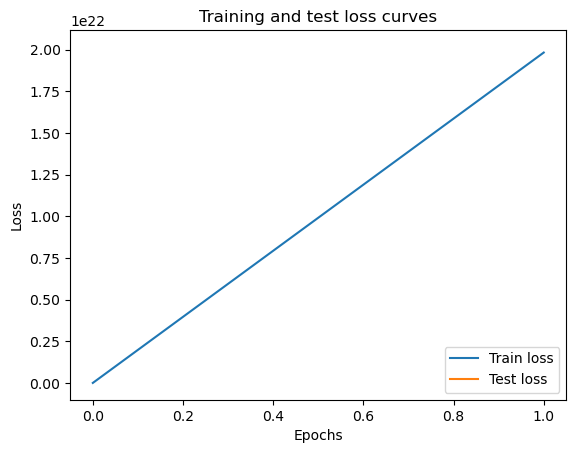

In [166]:
#Plot the loss curves
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [123]:
#Find model's learnt parameters
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([[nan],
        [nan],
        [nan]]))])
